In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
from scipy.stats import norm

from tqdm.auto import tqdm
from scipy.stats import chi2_contingency, chi2

### Задание 1.

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [2]:
# Выгрузим данные.

reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-kichigin/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-kichigin/shared/problem1-auth_data.csv', sep=';')

In [3]:
# Ознакомимся с данными, проведем первичный анализ.
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [5]:
# ПРАВКА: проверим дубликаты. используем, возможно, не самый элегантный способ.
reg_data[reg_data.duplicated()]

,reg_ts,uid


In [6]:
# Все строчки в данном датафрейме уникальны. Дубликатов нет.

In [7]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [8]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [10]:
# ПРАВКА: проделаем те же манипуляции (подсчет дубликатов) со вторым датафреймом.

In [11]:
auth_data[auth_data.duplicated()]

,auth_ts,uid


In [12]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

##### Выводы первичного анализа:

Пустые значения отсутствуют;\
Дубликатов нет;\
Unixtime необходимо будет перевести в дату.

In [13]:
# Функция по заданию:

def retention(reg, auth, reference_date, days):
    
    # Сначала введём дату, от которой будет считаться retention и в каком временном промежутке.
    # Сделаем перевод данных в Timestamp.
    
    start = pd.Timestamp(reference_date)
    end = start + pd.Timedelta(days=days)
    
    # Смержим два датасета, выгруженных ранее.
    
    df = reg.merge(auth, on='uid', how='left')
    
    # Переведем Unixtime дат регистрации и аутентификации в дни.
    
    df['date_of_authentication'] = pd.to_datetime(df.auth_ts, unit='s').dt.date
    df['date_of_registration'] = pd.to_datetime(df.reg_ts, unit='s').dt.date
    
    # Вычисляем разницу в днях между датами регистрации и аутентификации.
    
    df['diff'] = round(((df.auth_ts - df.reg_ts) / (60 * 60 * 24)), 0)
    
    # Сделаем фильтр, для того чтобы можно было самому задать дату, с которой будет считаться retention.
    
    df = df[(df.date_of_registration >= start) & (df.date_of_authentication <= end)]
    
    # Так как считаются дни, то значения долнжы быть целочисленные.
    
    df['diff'] = df['diff'].astype(int)
    
    # Создадим когорту с абсолютными значениями.
    
    df_cohort = df.pivot_table(index='date_of_registration', columns='diff', values='uid', aggfunc='count')
    
    # И выделяем индексы с днём регистрации пользователя.
    
    cohort_users_reg = df_cohort.iloc[:, 0]
    
    # А затем делим значения в столбцах на количество пользователей, в день регистрации.
    
    retention = df_cohort.divide(cohort_users_reg, axis=0)
    
    # Визуализируем ответ.
    
    plt.figure(figsize=(27, 23)) # ПРАВКА: увеличил размер графика. 
    # вероятно на маленьких экранах текст стал менее читабельным, но зато теперь все числа расположились внутри ячеек.
    plt.style.use('ggplot') # ПРАВКА: добавил строчку со стилем, как минимум чтобы даты с боку отображались корректно.
    plt.title('Retention', fontsize=18)
    sns.heatmap(retention, annot=True, cmap='vlag_r', fmt='.1%', vmin=0.0, vmax=0.1)
    plt.ylabel('Date of registration')
    plt.xlabel('Cohort')
    plt.show()
    
    # Так же ответ можно вернуть в табличном виде, прописав return retention.

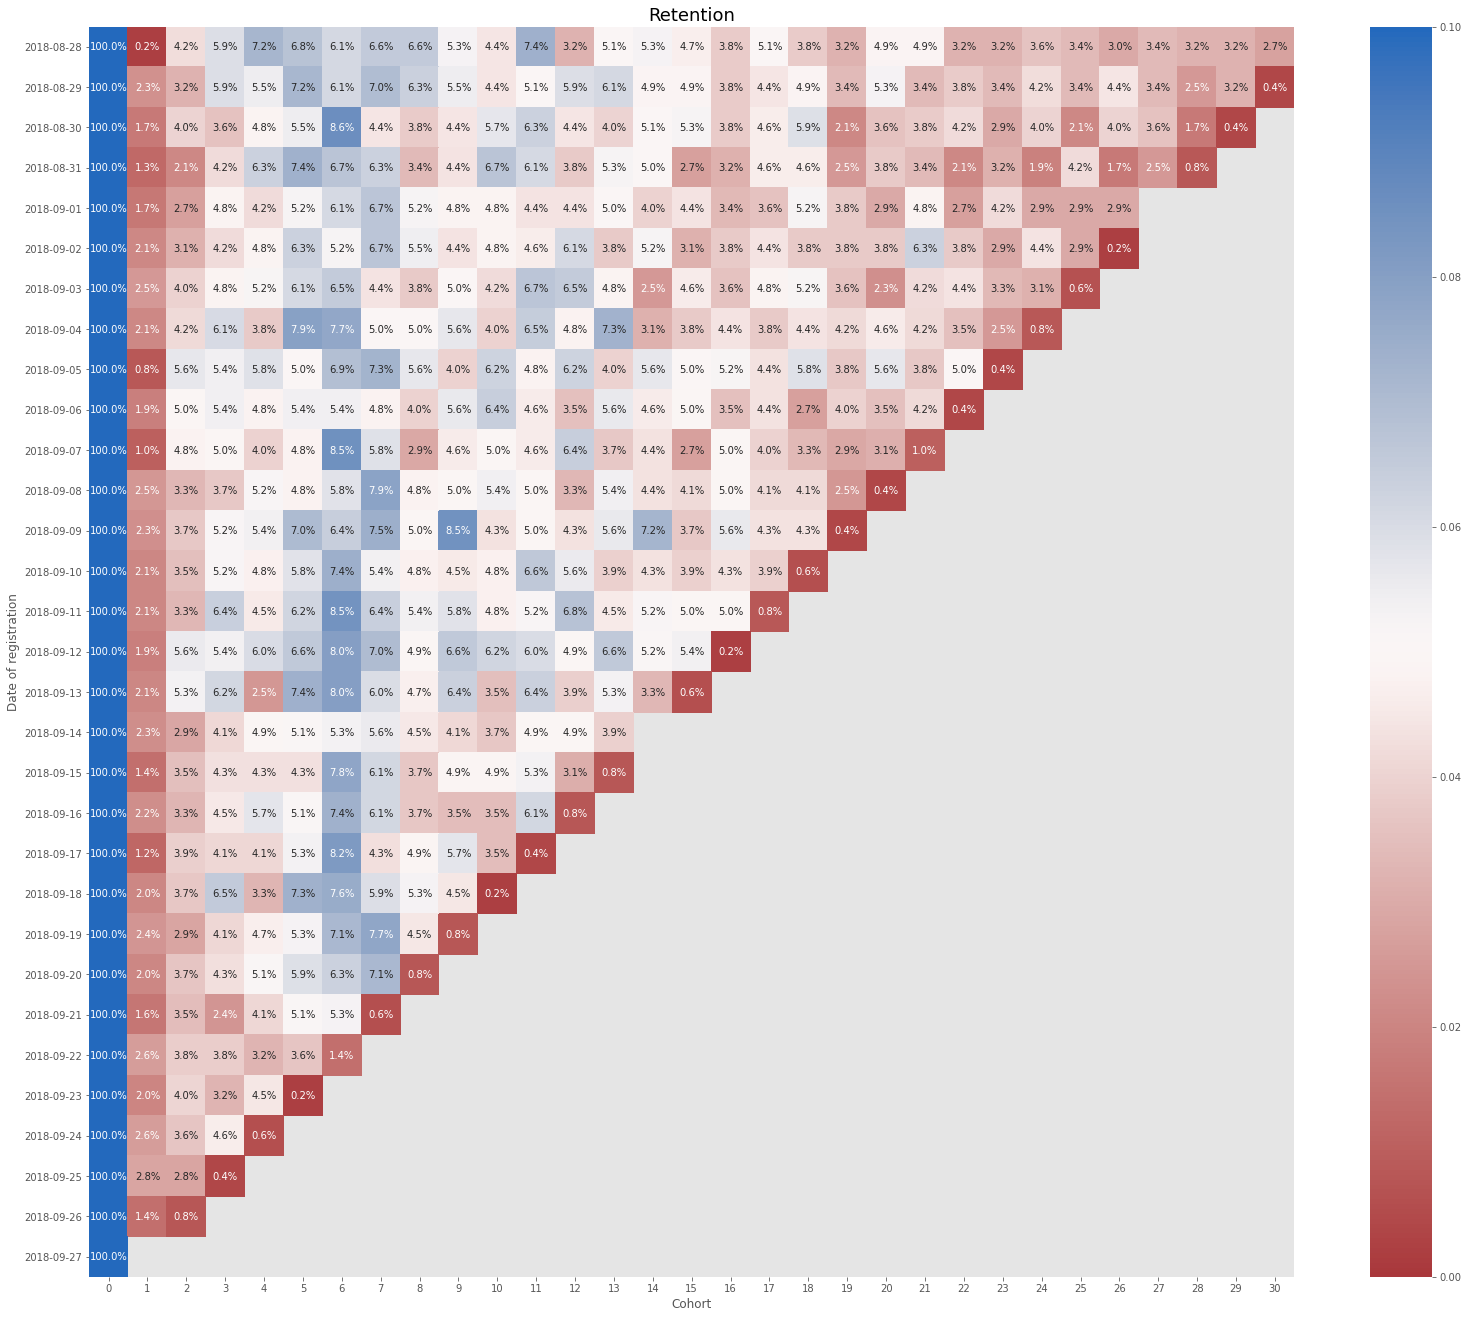

In [14]:
retention(auth_data, reg_data, '2018-08-28', 30)

### Задание 2.

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [15]:
# Загрузим данные и проведем первичный анализ.

In [16]:
customers_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-kichigin/Проект_1_Задание_2.csv', sep=';')
customers_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [17]:
customers_df.isna().sum() 

user_id      0
revenue      0
testgroup    0
dtype: int64

In [18]:
customers_df[customers_df.duplicated()] # и дубликаты

,user_id,revenue,testgroup


In [19]:
customers_df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [20]:
customers_df.shape # количество строк в датафрейме, совпадает с количеством уникальных пользователей в нём же.

(404770, 3)

Как мы видим - в датасете есть айди юзеров, сумма покупки, и разбивка по группам.

#### Вывод первичного анализа датафрейма:

Пропусков нет;\
Дубликатов нет;\
Пользователи не совершали более одной покупки.

Проведём более глубокий анализ датафрейма.

In [21]:
# Проведём анализ платежей, совершенных в группах.
customers_df.groupby(['testgroup'])\
            .revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


In [22]:
# И анализ платежей, среди совершивших покупку.
customers_df[customers_df.revenue > 0].groupby(['testgroup'])\
                                      .revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Как можно заметить, в группе "А" максимальное значение превышает максимальное значение в группе "В" почти в 10 раз. А так же можно отметить, что остальные показатели так же заметно различаются. Выглядит довольно странным.\
Визуализируем выручку в данных, для наглядности - возьмем только платящих пользователей.

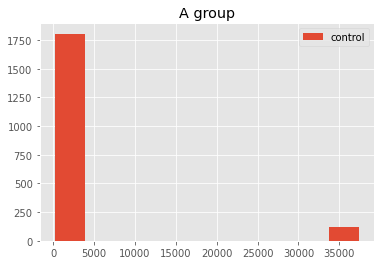

In [23]:
plt.hist(customers_df.query('revenue > 0 & testgroup =="a"').revenue, bins=10, label='control')
plt.title('A group')
plt.legend()

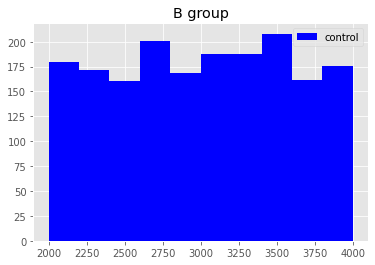

In [24]:
plt.hist(customers_df.query('revenue > 0 & testgroup =="b"').revenue, bins=10, label='control', color = 'blue')
plt.title('B group')
plt.legend()

Визуально распределение выглядит не нормальным. В группе В выручка распределена равномерно от 2000 до 4000. В группе А в этоже время платящие пользователи разделились на 2 подгруппы. Ошибка сплитирования? Или в этом и была цель акции?\
Рассмотрим группу А поближе.

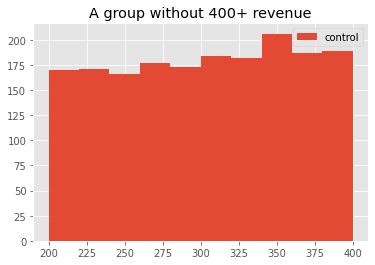

In [25]:
# Для начала глянем на распределение, если из него убрать этот самый выброс.
plt.hist(customers_df.query('revenue > 0 & revenue < 5000 & testgroup =="a"').revenue, bins=10, label='control')
plt.title('A group without 400+ revenue')
plt.legend()

Хм... Распределение стало более похоже относительно к группе В. Выручка равномерно распределилась в промежутке от 200 до 400. Давайте посмотрим как изменилась статистика без данного выброса:

In [26]:
customers_df.query('revenue > 0 & revenue <5000').groupby(['testgroup'])\
                                                 .revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1805.0,302.458172,57.914246,200.0,254.0,305.0,352.0,400.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Проявляется занимательная картина - количество юзеров стало равным между группами, но при этом все статистики в группе А теперь в 10 раз меньше чем в группе В. Вопросов к дизайну А/Б теста и исходным данным всё больше и больше. 

Посмотрим поближе на группу юзеров, которую мы "выбросили" в недавних манипуляциях.

In [27]:
users_a1 = customers_df.query('revenue > 5000').user_id.count()
users_a1_revenue = customers_df.query('revenue > 5000 & testgroup == "a"').revenue.sum()
users_a1_percent = users_a1_revenue*100/customers_df.query('testgroup == "a"').revenue.sum()
print('Пользователей, попавших в выброс: '+str(users_a1))
print('Процент выручки, который эти пользователи принесли: '+str(users_a1_percent.round(0))\
      +', что составляет '+str(users_a1_revenue))

Пользователей, попавших в выброс: 123
Процент выручки, который эти пользователи принесли: 89.0, что составляет 4590252


И посмотрим на общую выручку в группах, чтобы оценить масштаб трагедии.

In [28]:
total_revenue_a = customers_df.query('testgroup == "a"').revenue.sum()
total_revenue_b = customers_df.query('testgroup == "b"').revenue.sum()

print('Общая выручка в группе А: ' + str(total_revenue_a))
print('Общая выручка в группе В: ' + str(total_revenue_b))

Общая выручка в группе А: 5136189
Общая выручка в группе В: 5421603


Как оказалось - это подгруппа из 123 пользователя, которые приносят аж 89% (!) выручки во всей группе А. 4590252 единиц из 5136189 общей выручки.
Что это за группа пользователей? Как она образовалась? Условии акции?


Ошибка? Но покупку совершили 123 юзера, и не на одинаковую сумму. Вероятно надо уточнить, есть ли такие покупки вообще в акционном предложении.
У нас слишком мало информации, чтобы просто взять и убрать этих пользователей из анализа. К тому же мы ничего не знаем об идее данного А/Б теста, вдруг эта группа - как раз то, чего добивается компания? Нас просят выбрать "лучший набор предложений", но требуется уточнение - вдруг компания как раз хотела иметь такую "элиту". Не смотря на то, что остальные в группе А платят заметно меньше чем в группе В.

И еще немаловажно - если убрать эту подгруппу в группе А, то вероятно и без критериев будет видно (чуть выше), что группа В имеет успех, нежели группа А. Всё в 10 раз выше в группе В. Чудо, не иначе.

Но особых оснований убрать этих 123 пользователя у нас нет. Надо уточнять и задавать вопросы к дизайну А/Б теста, но об этом в выводе.

А пока - продолжаем анализ на основании существующих данных, в поисках "лучшего набора акционных предложений".

In [29]:
# Разграничим платящих пользователь от неплатящих.
customers_df['paid'] = np.where(customers_df.revenue > 0, 'paid', 'zero')
customers_df.head()

,user_id,revenue,testgroup,paid
0,1,0,b,zero
1,2,0,a,zero
2,3,0,a,zero
3,4,0,b,zero
4,5,0,b,zero


Из описания задания  мы знаем что в контрольной группе 1928 платящих пользователей, а в тестовой 1805. А так же что ARPU в тестовой на 5% выше чем в контрольной.

In [30]:
# Создадим два датасета.

In [31]:
df_a = customers_df.query('testgroup == "a"')
df_b = customers_df.query('testgroup == "b"')

In [32]:
df_paid = customers_df.groupby(['testgroup', 'paid'], as_index = False)\
                      .agg({'user_id':'count'})\
                      .pivot(index = 'testgroup', columns='paid', values='user_id')

In [33]:
df_paid['conversion'] = round((df_paid.paid / df_paid.zero) * 100, 2)
df_paid

paid,paid,zero,conversion
testgroup,,,
a,1928,200175,0.96
b,1805,200862,0.90


In [34]:
ARPU_a = df_a.revenue.sum() / df_a.user_id.nunique()
ARPU_b = df_b.revenue.sum() / df_b.user_id.nunique()
ARPPU_a = df_a.revenue.sum() / df_a.query('revenue > 0').user_id.nunique()
ARPPU_b = df_b.query('revenue > 0').revenue.sum() / df_b.query('revenue > 0').user_id.nunique()

In [35]:
d = {'Group':['A', 'B'], 'ARPU':[ARPU_a, ARPU_b], 'ARPPU':[ARPPU_a, ARPPU_b]}
df = pd.DataFrame(data=d)
df

,Group,ARPU,ARPPU
0,A,25.413720,2663.998444
1,B,26.751287,3003.658172


In [36]:
Result_ARPU = round((ARPU_b - ARPU_a) / ARPU_b, 4) * 100
Result_ARPPU = round((ARPPU_b - ARPPU_a) / ARPPU_b, 4) * 100
print('ARPU: ' + str(Result_ARPU))
print('ARPPU: ' + str(Result_ARPPU))

ARPU: 5.0
ARPPU: 11.31


ARPU группы А на 5% меньше чем у группы В.\
ARPPU группы А на 11.31% меньше чем у группы В.\
Консверсия в группе А больше на 0,06%, чем в группе В.\
В группе А - 1928 платящих пользователей, в группе В - 1805.

Полученные значения указывают на то, что группа А - контрольная, а группа В - тестовая.

Продолжим.

In [37]:
# Переименуем датасеты, для удобства.
 
df_control = df_a.copy()
df_test = df_b.copy()

# И создадим еще два, для ARPPU

df_control_arppu = df_control.query('revenue > 0')
df_test_arppu = df_test.query('revenue > 0')

Визуализируя данные чуть выше, мы уже сделали вывод что данные распределены не нормально.
Применим "Шапиро-Уилка", чтобы убедиться в этом окончательно. Нулевая гипотеза - распределение нормальное, альтернативная - распределение не нормальное.

In [38]:
# Сделаем сэмплы. ARPU.
control = df_control.revenue.sample(1000)
test = df_test.revenue.sample(1000)
print(scipy.stats.shapiro(control))
print(scipy.stats.shapiro(test))

ShapiroResult(statistic=0.048720598220825195, pvalue=0.0)
ShapiroResult(statistic=0.07788538932800293, pvalue=0.0)


In [39]:
# Сделаем сэмплы. ARPPU.
control1 = df_control_arppu.revenue.sample(1000)
test1 = df_test_arppu.revenue.sample(1000)
print(scipy.stats.shapiro(control1))
print(scipy.stats.shapiro(test1))

ShapiroResult(statistic=0.26724910736083984, pvalue=0.0)
ShapiroResult(statistic=0.9576759934425354, pvalue=2.083954101338571e-16)


Шапиро-Уилка показал что распределение не нормальное.

Продолжим исследование.


Попытаемся ответить на вопрос, на основании имеющихся данных - какой же акционный набор всё таки "лучше"?.\
Сформируем три пары новых гипотез - ARPU, ARPPU, Конверсия.\
Нулевая гипотеза - разница статистически не значима.\
Альтернативная - разница между группами статистически значима.

Посмотрим, можем ли мы тут применить t-test при сравнении ARPU и ARPPU.

Что нам известно про t-test:\
Критерий, который позволяет сравнивать две выборки между собой (два выборочных средних).

Когда можно применить t-test:\
1) нормальное распределение и известная дисперсия;\
2) нормальное распределение, малая выборка, неизвестная дисперсия;\
3) нормальное распределение, неизвестные дисперсии, зависимые выборки;\
4) любое распределение, неизвестная дисперсия и большая выборка (по классике, больше 30 наблюдений, хотя это весьма зыбкий критерий).

Вероятно 4 случай - как раз наш. Ведь именно когда выборка становится большая, то распределение не имеет значения, потому что требование к тесту касается не самого распределения, а распределения средней. Оно должно быть нормальным.

Само же распределение в группе у нас не нормальное, напомню.

In [55]:
# Объявим функцию, для проверки распределения среднего в наших группах.

def mean_distribution(data1, data2, boot_it, statistic=np.mean):

    boot_len_a = len(data1)
    boot_len_b = len(data2)
    
    # списки для средних из цикла
    
    boot_data_shapiro_a = [] 
    boot_data_shapiro_b = []
    
    for i in tqdm(range(boot_it)):
        
        # извлечем подвыборки
        
        samples_a = data1.revenue.sample(boot_len_a, replace=True).values
        
        samples_b = data2.revenue.sample(boot_len_b, replace=True).values
        
        # добавляем средние значения в списки выше
        
        boot_data_shapiro_a.append(statistic(samples_a))
        boot_data_shapiro_b.append(statistic(samples_b))
        
    # Применяем критерий Шапиро-Уилка на каждом из списков
    # Нулевая гипотеза - распределение нормально
    # Альтернативная - распределение не нормальное
    
    shapiro_a = scipy.stats.shapiro(boot_data_shapiro_a)
    shapiro_b = scipy.stats.shapiro(boot_data_shapiro_b)
    
    # Для визуализации
    
    pd_boot_data_a = pd.DataFrame(boot_data_shapiro_a)
    pd_boot_data_b = pd.DataFrame(boot_data_shapiro_b)
    
    plt.hist(pd_boot_data_a[0], bins = 50)
    plt.hist(pd_boot_data_b[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of mean distribution")
    plt.show()
    
    # Вернем значения Шапиро-Уилка
    
    return shapiro_a, shapiro_b

Применим функцию, объявленную ранее.

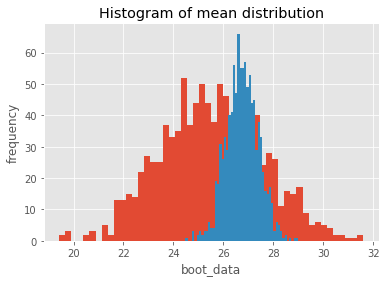

(ShapiroResult(statistic=0.9984230995178223, pvalue=0.5054065585136414),
 ShapiroResult(statistic=0.998729944229126, pvalue=0.7086455225944519))

In [41]:
# Посмотрим как распределяются средние значения среди всех пользователей

mean_distribution(df_control, df_test, 1000)

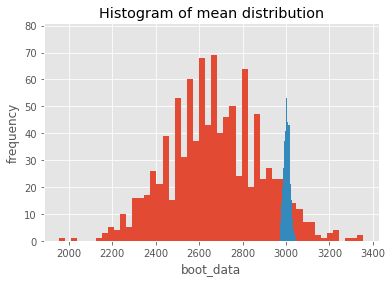

(ShapiroResult(statistic=0.9982495307922363, pvalue=0.40321633219718933),
 ShapiroResult(statistic=0.9984943270683289, pvalue=0.5509564876556396))

In [42]:
# Посмотри как распределяется средняя внутри групп, но уже только среди платящих пользователей

mean_distribution(df_control_arppu, df_test_arppu, 1000)

In [43]:
# Если проводить сравнение средних без "выброса" - то картина становится еще более прозрачной,
# но еще больше видно колоссальную разницу между двумя группами без этой подгруппы. 
# Поэтому этот "условный шаг" под комментарием. Но тоже был осмотрен.

#mean_distribution(df_control.query('revenue < 5000'), df_test, 1000)
#mean_distribution(df_control_arppu.query('revenue < 5000'), df_test_arppu, 1000)

В результате многократных выборок, распределение средних внутри групп как среди всех пользователей, так и исключительно платящих пользователей - можно сказать что имеют нормальное распределение (p-value достатночно намного превышает 0.05, отклонить нулевую гипотезу нет оснований).

В таком случае, попробуем применить t-test для сравнения ARPU и ARPPU наших групп.

Нулевая гипотеза - статистически значимой разницы нет.\
Альтернативная - статистически значимая разница между группами есть.

In [44]:
scipy.stats.ttest_ind(df_control.revenue, df_test.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

In [45]:
scipy.stats.ttest_ind(df_control_arppu.revenue, df_test_arppu.revenue)

Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)

T-test и в случае ARPU и в случае ARPPU показал между группами отсутствие статистически значимых различий (p-value заметно больше 0.05, что не позволяет нам отклонить нулевую гипотезу)

Чтобы убедиться в этом, проведём еще бутстрап, для общей картины.

In [46]:
# Напишем функцию, с помощью которой будем проводить бутстрап выборок.
def bootstrap(data_column_1, data_column_2, boot_it=10000, statistic=np.mean, bootstrap_conf_level=0.95):
# Где:
# data_column_1 - числа из первой выборки
# data_column_2 - числа из второй выборки
# boot_it - количество бутстрап подвыборок
# statistic - среднее
# bootstrap_conf_level - уровень значимости.
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлечем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace=True).values
        
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(samples_1 - samples_2)) # выбирается среднее (np.mean)
        
    pd_boot_data = pd.DataFrame(boot_data)

    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    
    p_value = min(p_1, p_2) * 2
    
# ПРАВКА: подтянем визуализацию из лекции, что поможет нам в итоговом ответе.
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data_mean")
    plt.show()
    
    return {'boot_data':boot_data,
            'ci':ci,
            'p_value':p_value}

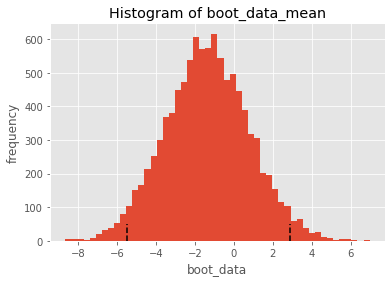

0.527225562027472

In [47]:
# И проведем bootstrap анализ.

booted_data_1 = bootstrap(df_control.revenue, df_test.revenue, boot_it=10000)
booted_data_1['p_value']

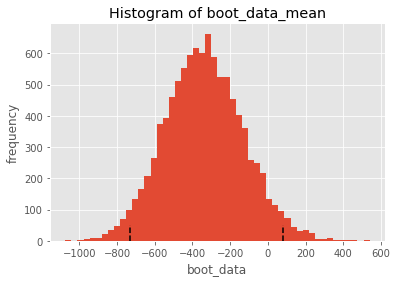

0.10339241746706747

In [48]:
booted_data_2 = bootstrap(df_control_arppu.revenue, df_test_arppu.revenue, boot_it=10000)
booted_data_2['p_value']

Как видим, в обоих случаях - p-value > 0.05, и 0 попадает в доверительный интервал. Следовательно - мы не можем отклонить нулевую гипотезу. Напомню, нулевая гипотеза - разница между выборками статистически не значима.

Теперь проверим конверсию.

Нулевая гипотеза - между контрольной и тестовой группах статистически значимой разницы нет, альтернативная - разница статестически значима.

In [49]:
# Для проверки гипотез используем "Хи-Квадрат".
df_chi = customers_df.groupby(['testgroup', 'paid'], as_index=False)\
                     .agg({'user_id' : 'count'})\
                     .pivot(index='paid', columns='testgroup', values='user_id')

In [50]:
stat, p, dof, prob = chi2_contingency(df_chi)

In [51]:
stat, p

(4.374729521260405, 0.03647561892312613)

In [52]:
# А теперь сравним значения статистики и p-value с пороговыми значениями.
a = chi2.ppf(0.95, dof)
print(stat >= a)
print(p < 0.05)

True
True


#### Вывод по второму заданию:

Какой набор акционных предложений в итоге оставить? Сложно однозначно ответить.

Во-первых - очень много вопросов к дизайну теста и набору данных:

Не ясно какая конечная идея теста. Поиск "лучшего набора предложений" - это не идея. А пальцем в небо. Нужна конкретика - что, зачем, какую метрику мы хотим подтянуть. Нужна ли нам эта "элита" в контрольной группе, или мы наоборот жаждем от нее избавиться и получать более стабильную выручку как в тестовой группе. Или всё же - мы целимся в "премиум" сегмент?;\
О количестве пользователей тоже ничего не известно. О том, сколько в тесте учавствовало пользователей из общего числа пользователей нашего продукта.;\
Вопросы имеются и к сплитированию. Как разбиты группы? Сплитированы ли они объективно? Или всё таки есть ошибка в сплитировании? Вдруг в контрольную группу попали пользователи из определенного "зажиточного" города (условно), из которого не попали люди в тестовую? Возможно и там заплатили бы 37 тысяч.;\
Сколько шло тестирование? Сколько нам позволили, и сколько мы бы могли еще понаблюдать? Вероятно картина бы поменялась, через день, два или неделю.

Но если отталкиваться от того, что мы имеем (условий задания, и датафрейма в нём), и провести анализ - можно сделать некоторые выводы:

По ходу анализа в контрольной группе было обнаружено наличие двух подгрупп пользователей. Одни из них платят 200-400 единиц, другие - 37к+. При этом, платящих 37к+ - 123 человека, и в общем итоге они приносят 89% от всей выручки в контрольной группе. А это ни много ни мало - 4590252 единиц. Рассмотрев ситуацию "поближе" - у нас нет весомых аргументов исключить эту подгруппу из анализа. 
В противном же случае, если мы исключим - анализ и не требуется. Ведь в тестовой группе все показатели становятся в ~10 раз больше, нежели в контрольной. Различия видны и без тестов и критериев. И общая выручка в контрольной группе составит всего лишь - 545937, против тестовой - 5421603. Должно ли было так случится? Вопрос к конечной идее теста. Да и в целом к дизайну.

Основной анализ был проведён с учетом этой группы "элиты". Был применён t-test, и проверен бутстрап при сравнении ARPU и ARPPU между группами. Статзначимых различий обнаружено небыло.

Так же была проверена конверсия, с помощью Хи-квадрата. И вот тут уже имеется статзначимая различия в пользу контрольной группы. Но даёт ли нам это основание не принимать тестовый набор акций? Опять же - не всё так однозначно. Приняв тестовый набор, мы потеряем в конверсии согласно анализу. Но получим более "надежную" платёжную аудиторию, которая будет платить регулярно и примерно предсказуемые суммы, нежели в контрольной, где есть "элита". И если мы такую элиту потеряем, хотя бы 1 человека - это отразится на метриках в контрольной группе заметно больше, нежели в тестовой. Но опять же, во многом всё зависит от того, чего мы добивались акционными наборами. Если как раз таки продажу каких-либо "крупных наборов" (за 37к) - то тогда конечно же контрольная группа наш фаворит.

Но всё же, вероятно, на мой взгляд, тестовый вариант выглядит более перспективным. С ним и работать будет проще и выкатывать новые акционные предложения, нежели тестировать новые предложения на группе с выбросами (или элитными пользователями), поведение которых будет влиять на многое и очень сильно. 

И немного цифр:

Общая выручка: 

1) Контрольная группа: 5136189, поделена на две подгруппы: \
    1.1) одна подгруппа 1805 пользователей, с выручкой от 200 до 400, что принесли в общей сложности 545937 единиц выручки (11% от всей контрольной группы);\
    1.2) вторая подгруппа 123 пользователя, c выручкой от 37293 до 37433, что принесли в общей сложности 4590252 единиц выручки (89% от всей контрольной группы).

2) Тестовая группа: 5421603 единиц выручки, распределена равномерно между 1805 пользователями.

ARPU: В контрольной группе (25.4 единиц) на 5% меньше, чем в тестовой группы (26.7 единиц), статзначимой разницы не обнаружено;\
ARPPU: В контрольной группе (2663.99 единиц) на 11.31% меньше, чем в тестовой группе (3003.65 единиц), статзначимой разницы так же не обнаружено;\
Консверсия: В контрольной группе (0.96%) выше на 0.06%, чем в тестовой группе (0.9%), статзначимая разница была обнаружена.


#### Задание 3.
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### Ответ:
Daily, Weekly, Monthly Active Users - для анализа количества активных пользователей, во время события. Собственно - день, неделя или месяц, в зависимости от длительности мероприятия;\
Conversion - чтобы видеть конверсию в покупку у пользователей, во время события. И естественно сравнить с тем что было до. Проверять раз в день;\
Retention - чтобы анализировать динамику заинтересованности пользователей во время события. Отслеживать в зависимости от длительности события. Возможно и раз в неделю, и раз в день;\
ARPU и ARPPU - анализировать оценку прибыльности во время события, чтобы выяснить насколько пользователи готовы платить, или наоборот - стали недоплачивать;\
Lifetime value - смотреть как изменился показатель за всё время события.

Метрики ниже в основном будут отображать показатели события, именно с точки зрения "технической реализации". Потому что если игра плохо сбалансирована, или вызывает трудности - играть в нее явно будет меньше людей, что отразится на метриках выше.

На какому уровне больше всего останавливались пользователи;\
Количество пользователей дошедших до уровня N;\
Среднее попыток прохождение на каждый уровень;\
Среднее количество попыток, перед потерей пользователя.

Всё метрики необходимо смотреть по ходу ивента, разумеется. И делать вывод после окончания события, о том что пошло не так, или наоборот - что получилось реализовать хорошо. И что нужно сделать, чтобы пользователь вернулся на событие, и даже возможно привёл с собой еще "друзей". 

После усложнения, существующий набор метрик особо неизменится, но дополнится. Опять же с точки зрения "приятности" продукта. Как я уже отмечал - идея усложнения звучит сомнительно, и всё же, поскольку мы решим ее выкатить - будем наблюдать и за метриками выше, и более тщательно следить за тем как у нас меняется Retention. То есть да, в целом всё (в том числе и метрики ниже) будут влиять на заинтересованность пользователей в данном изменении. Насколько они готовы к таким сложностям, и готовы ли платить за них. Или всё убегут еще в середине события. А затем еще хуже - вообще не вернутся.

Сколько пользователей ниразу не откатились назад по уровням?;\
Насколько уровней откатывался пользователь назад в среднем, прежде чем покинуть проект?;\
Насколько уровней откатывался пользователь в среднем, который закончил игру?;\
Сколько людей вернулось после ивента, которые бросили игру во время ивента.

